1. Reading combined extracted data

In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

In [185]:
pd.set_option('display.max_columns', None)   # show all columns

In [186]:
df = pd.read_csv('combined_accidents.csv')
df.head()

,publish_date,content,time_24h,corrected_date,injury_severity,affected_party,car,motorbike,larger_vehicle,collision,running_over_pedestrian,lost_control,crushed_into_obstacle,overturned,primary_accident_type_code,age,min_age,max_age,location,street,locality,day_of_week_num,rush_hour,rain_today,rain_last_3h,temp_avg,temp_min,temp_max,precip_mm_day,roadworks_nearby
0,2025-10-09,"Today, at around 0930hrs, the Police were info...",09:30,2025-10-09,serious,motorcyclist,1,1,0,1,0,0,0,0,COLL,"['67', '61']",61.0,67.0,"Triq il-Belt Valletta, Żurrieq",Triq il-Belt Valletta,Żurrieq,3,1,False,False,20.4,16.0,25.0,0.0,False
1,2025-06-20,"Yesterday, at around 1830hrs, the Police were ...",18:30,2025-06-19,grievous,motorcyclist,1,1,0,1,0,0,0,0,COLL,"['64', '23']",23.0,64.0,"Triq Dawret il-Gudja, Gudja",Triq Dawret il-Gudja,Gudja,3,1,False,False,24.8,21.0,29.5,0.0,False
2,2025-05-12,"Today, at around 0800hrs, the Police were info...",08:00,2025-05-12,grievous,motorcyclist,1,1,0,1,0,0,0,0,COLL,"['34', '29']",29.0,34.0,"Valley Road, Qormi",Valley Road,Qormi,0,1,False,False,21.1,17.9,25.4,0.0,False
3,2025-07-30,"Yesterday, at around 1800hrs, the Police were ...",18:00,2025-07-29,grievous,motorcyclist,1,1,0,1,0,0,0,0,COLL,"['42', '29']",29.0,42.0,"Triq Dawret Ħal Għaxaq, Għaxaq",Triq Dawret Ħal Għaxaq,Għaxaq,1,1,False,False,25.7,22.8,29.3,0.0,False
4,2025-04-07,"Yesterday, at around quarter to nine in the ev...",20:45,2025-04-06,grievous,motorcyclist,1,1,0,1,0,0,0,0,COLL,"['25', '41']",25.0,41.0,"Triq il-Buqana, Rabat",Triq il-Buqana,Rabat,6,0,False,False,15.5,11.5,19.3,0.0,False


In [187]:
#dropping columns with dates and content
df.drop(['publish_date', 'content'], axis=1, inplace=True)

2. Value counts and visualisations Part 1: Injury Severity and Affected Party

In [188]:
#injuiry severity value counts
df['injury_severity'].value_counts()

#note: no injuries can be grouped together with minor injuries for analysis purposes. Critical and grievous injuries can be also grouped. 
#the grievous castegory is the largest and can be reduced to balance the dataset more.


injury_severity
grievous       109
serious         73
minor           19
death           14
critical         5
no injuries      3
Name: count, dtype: int64

In [189]:
df['injury_severity'] = df['injury_severity'].replace({'no injuries':'minor', 'critical':'grievous'})
df['injury_severity'].value_counts()

injury_severity
grievous    114
serious      73
minor        22
death        14
Name: count, dtype: int64

In [190]:
#injuiry severity value counts
df['affected_party'].value_counts()

#note: cyclist and pedestrian can be grouped together

affected_party
motorcyclist    110
pedestrian       55
driver           52
cyclist           6
Name: count, dtype: int64

In [191]:
#df['affected_party'] = df['affected_party'].replace({'cyclist':'pedestrian'})
#df['affected_party'].value_counts()

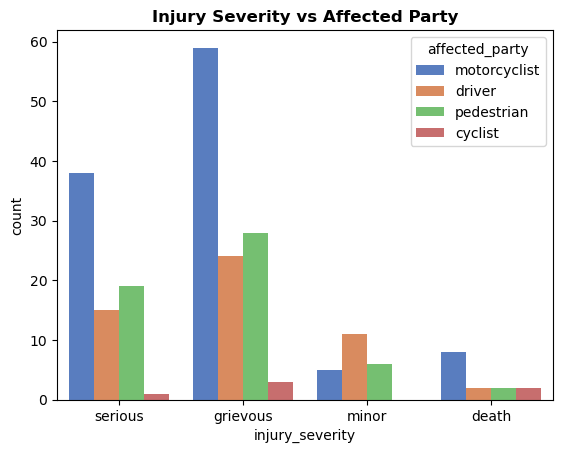

In [192]:
#1. Injury severity vs affected party
ax=sns.countplot(x="injury_severity", hue = 'affected_party', data=df, palette = "muted")
ax.set_title('Injury Severity vs Affected Party', fontsize=12, fontweight='bold')
plt.show()

#motorcyclists are fatalists

In [193]:
#accident severity vs vehicles involved
#encoding vehicle types in the following way: motorcycle - 1 , car - 2, larger vehicles - 3. A sum of the vehicle types is stored in a new column 'vehicle_type_score'"AI journal"
# if the sum is 1, it means only a motorcycle was involved, 2 - only a car, 3 - a car and a motorcycle or only a larger vehicle, 4 - a larger vehicle and a motorcycle, 5 - all three types

df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})

df['car'] = df['car'].replace({1:2, 0:0})
df['larger_vehicle'] = df['larger_vehicle'].replace({1:4, 0:0})
df['vehicle_type_score'] = df['car'] + df['motorbike'] + df['larger_vehicle'] 
df['primary_accident_type_code'].value_counts()
df['vehicle_type_score'].value_counts()

vehicle_type_score
2    75
3    73
1    36
6    24
7     9
5     3
0     2
4     1
Name: count, dtype: int64

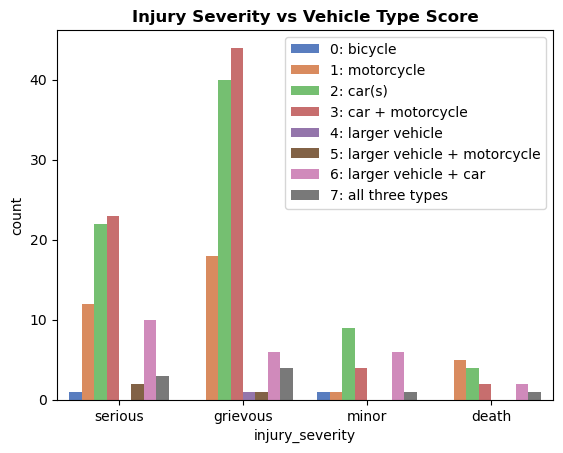

In [194]:
#injury severity vs vehicle type score
ax = sns.countplot(x="injury_severity", hue = 'vehicle_type_score', data=df, palette = "muted")
ax.set_title('Injury Severity vs Vehicle Type Score', fontsize=12, fontweight='bold')
ax.legend(labels = ['0: bicycle', '1: motorcycle', '2: car(s)', '3: car + motorcycle', '4: larger vehicle', '5: larger vehicle + motorcycle','6: larger vehicle + car', '7: all three types'], loc='best')
plt.show()

In [195]:
#correcting the accident type code based on the vehicle type score
idx_coll = df.loc[(df['vehicle_type_score']  > 2) & (df['larger_vehicle']==0)&(df['primary_accident_type_code'] != 'COLL')].index
df.loc[idx_coll, 'primary_accident_type_code'] = 'COLL'

In [196]:
#injuiry severity value counts
df['primary_accident_type_code'].value_counts()

#note: loc (lost control), roll (overturned) and other can be grouped together

primary_accident_type_code
COLL     107
PED       51
FXOBJ     49
OTH       16
Name: count, dtype: int64

In [197]:
df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})
df['primary_accident_type_code'].value_counts()

primary_accident_type_code
COLL     107
PED       51
FXOBJ     49
OTH       16
Name: count, dtype: int64

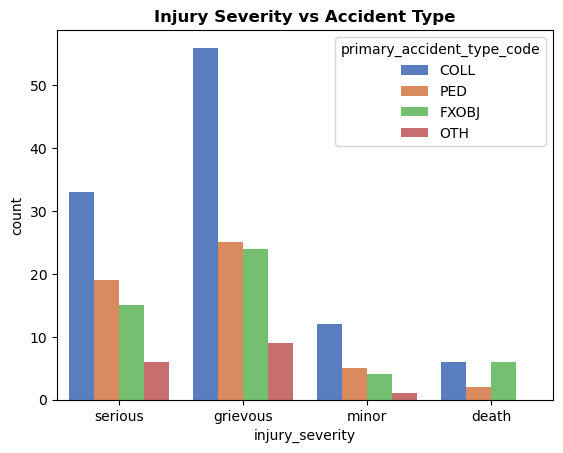

In [198]:
# 2. Injury severity vs primary accident type code
ax = sns.countplot(x="injury_severity", hue = 'primary_accident_type_code', data=df, palette = "muted")
ax.set_title('Injury Severity vs Accident Type', fontsize=12, fontweight='bold')
plt.show()

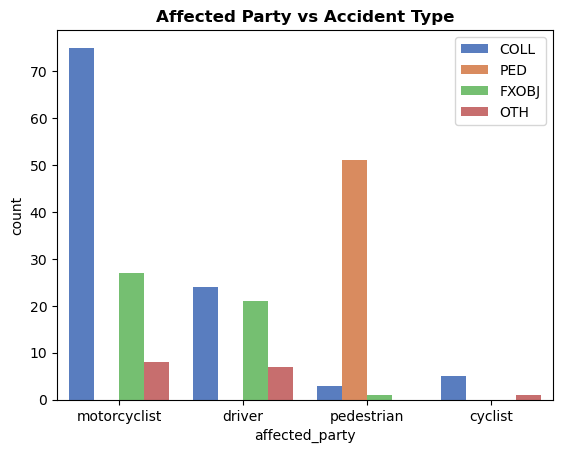

In [199]:
#3. Affected party vs primary accident type code
ax = sns.countplot(x="affected_party", hue = 'primary_accident_type_code', data=df, palette = "muted")
ax.set_title('Affected Party vs Accident Type', fontsize=12, fontweight='bold')
ax.legend(loc='best')
plt.show()

#this shows that leading types of accidents for motorcyclysts are collision, followed by crushing into obstacles;
#for drivers, collisions and crushing into obstacles are equally frequent;
#the pedestrian category should have only one accident type - running over pedestrians, but since we joined it with the cyclist category, it shows collisions as well.

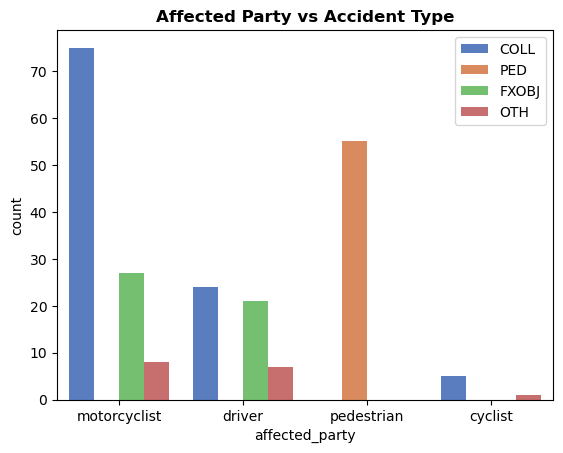

In [200]:
#correcting the accident type for pedestrians: all pedestrians are involved only in PED accidents
idx_ped = df.loc[(df['affected_party']  == 'pedestrian') & (df['primary_accident_type_code'] != 'PED')].index
df.loc[idx_ped, 'primary_accident_type_code'] = 'PED'

#3. Affected party vs primary accident type code
ax = sns.countplot(x="affected_party", hue = 'primary_accident_type_code', data=df, palette = "muted")
ax.set_title('Affected Party vs Accident Type', fontsize=12, fontweight='bold')
ax.legend(loc='best')
plt.show()

C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\136133507.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="day_of_week_num", data=df, legend="False",palette = "muted")


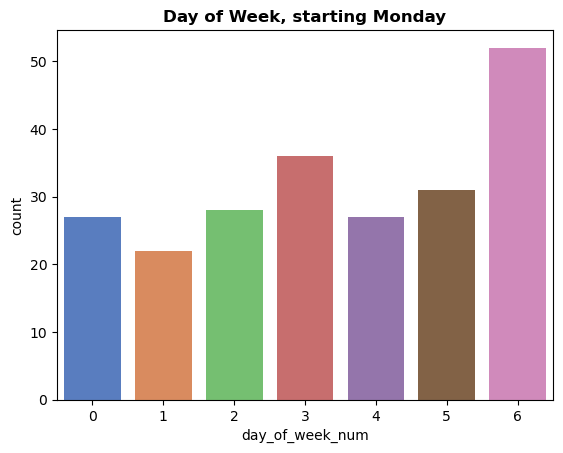

In [201]:
#day of week analysis
ax = sns.countplot(x="day_of_week_num", data=df, legend="False",palette = "muted")
ax.set_title('Day of Week, starting Monday', fontsize=12, fontweight='bold')
plt.show()


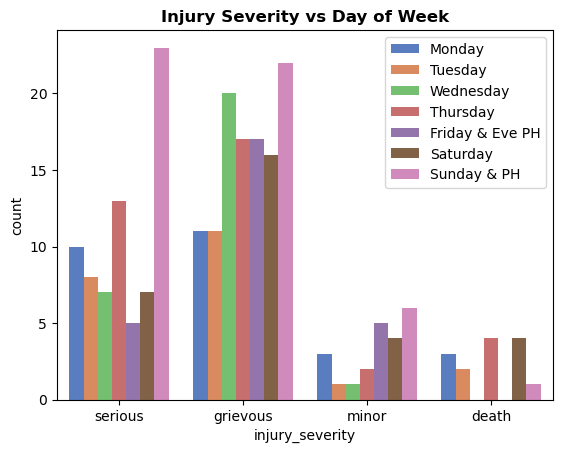

In [202]:
#5. Injury severity vs day of the week
ax = sns.countplot(x="injury_severity", hue = 'day_of_week_num', data=df, palette = "muted")
ax.set_title('Injury Severity vs Day of Week', fontsize=12, fontweight='bold')
ax.legend(labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday & Eve PH', 'Saturday','Sunday & PH'], loc='best')
plt.show()
#there're a peak midweek and on Sunday & there is a similarity between Monday&Tuesday and Friday & Saturday

<Axes: xlabel='injury_severity', ylabel='count'>

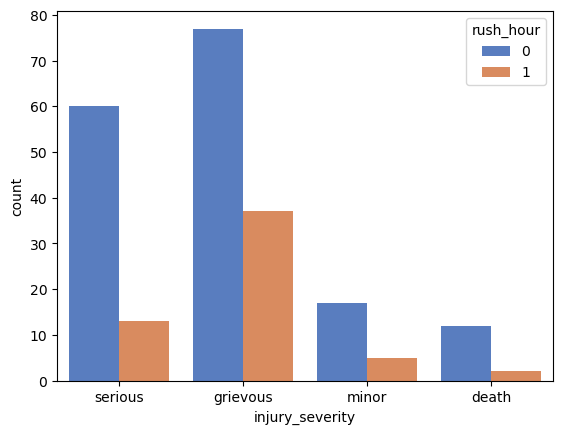

In [203]:
#4. Injury severity vs rush hour
sns.countplot(x="injury_severity", hue = 'rush_hour', data=df, palette = "muted")

<Axes: xlabel='primary_accident_type_code', ylabel='count'>

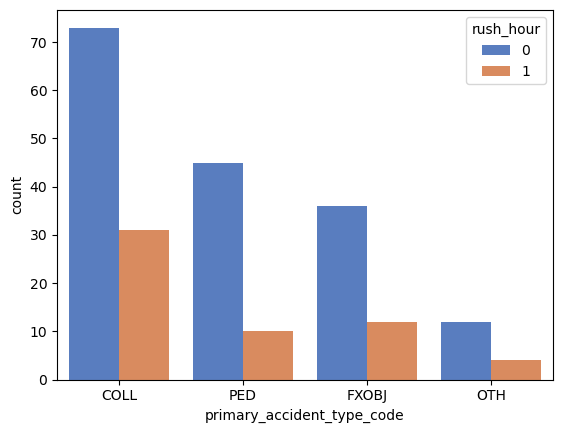

In [204]:
#4. Accident type vs rush hour
sns.countplot(x="primary_accident_type_code", hue = 'rush_hour', data=df, palette = "muted")

#the majority of collisions and running over pedestrians happen outside rush hour

<Axes: xlabel='primary_accident_type_code', ylabel='count'>

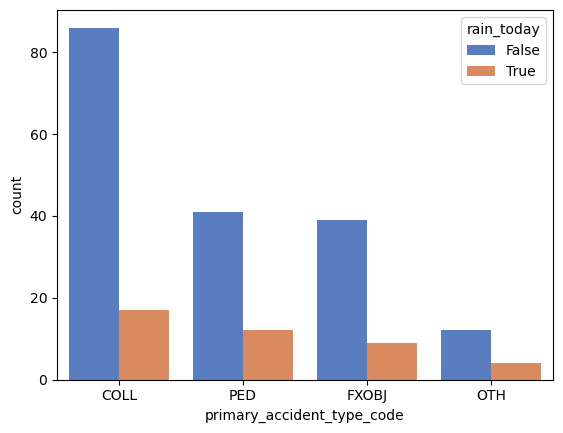

In [205]:
#5. Accident type vs rush hour
sns.countplot(x="primary_accident_type_code", hue = 'rain_today', data=df, palette = "muted")

<Axes: xlabel='injury_severity', ylabel='count'>

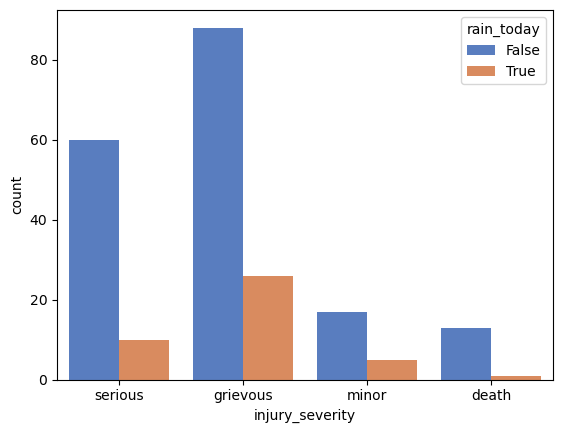

In [206]:
#5. Injury severity vs rush hour
sns.countplot(x="injury_severity", hue = 'rain_today', data=df, palette = "muted")

In [207]:
df['day_of_week_num'].value_counts()

day_of_week_num
6    52
3    36
5    31
2    28
0    27
4    27
1    22
Name: count, dtype: int64

<Axes: xlabel='injury_severity', ylabel='count'>

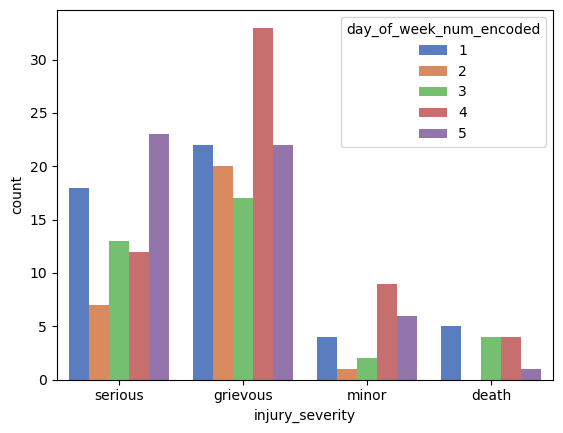

In [208]:
#encoding day of week this way: Monday (0) & Tuesday (1) = 1, Wednesday (2)  = 2 & Thursdays (3) are 3, Friday (4) & Saturday (5) is 4, Sunday (6) is 5
df['day_of_week_num_encoded'] = df['day_of_week_num'].replace({0:1, 1:1, 2:2, 3:3, 4:4, 5:4, 6:5})
sns.countplot(x="injury_severity", hue = 'day_of_week_num_encoded', data=df, palette = "muted")

In [209]:
#since grievous injuries with motorcyclists and collisions are the most frequent, we can reduce these to balance the dataset
idx_GriMotoColl = df.loc[(df['injury_severity']  == 'grievous') & (df['affected_party']  == 'motorcyclist') & (df['primary_accident_type_code'] != 'FXOBJ')].index
#idx_GriMotoColl = df.loc[(df['injury_severity']  == 'grievous') & (df['affected_party']  == 'motorcyclist') & (df['primary_accident_type_code'] != 'COLL')].index
idx_GriMotoColl


Index([  1,   2,   3,   4,   5,   8,  19,  22,  27,  29,  31,  32,  34,  38,
        39,  44,  46,  49,  51,  57,  60,  68,  73,  75,  77,  82,  85,  91,
        96,  97,  99, 124, 126, 146, 147, 150, 155, 160, 168, 169, 171, 183,
       200, 201, 212, 213, 218, 219],
      dtype='int64')

In [210]:
idx_GriMotoColl.size
#there are a lot of records of grievously injuired motorcyclists who crushed into fixed objects
#how to handle unbalanced data:
# https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/
#we can divide grievous and serious class in two groups and use the two minority classes with each of those two groups
#https://www.youtube.com/watch?v=ok2s1vV9XW0

48